21/04

In [1]:
%cd ..

/home/ltorres/leo/tesis/cloud-classification/code


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from torchvision.io import read_image
from torchvision.utils import make_grid
import glob
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from random import sample
import torch
import torch.nn as nn
from sklearn import preprocessing
import networkx as nx

In [4]:
from src.dataset import GCD
from src import config
from src import engine_gnn as engine
from src import utils

from src.models.old.initial_graphnets import GraphConvGNN, GATConvGNN

#from notebooks.adjacency_construction.adjacency_models import GATConvGNN

In [5]:
import torchvision.transforms.functional as F


plt.rcParams["savefig.bbox"] = 'tight'


def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False, figsize=(50,100))
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

# 1. Evaluacion de predict utilizando un banco de imagenes de entrenamiento

In [6]:
paths = [
    '/data/mandonaire/GCD/train/1_cumulus/1_cumulus_000082.jpg',
    '/data/mandonaire/GCD/train/1_cumulus/1_cumulus_000127.jpg',
    '/data/mandonaire/GCD/train/2_altocumulus/2_altocumulus_000003.jpg',
    '/data/mandonaire/GCD/train/2_altocumulus/2_altocumulus_000028.jpg',
    '/data/mandonaire/GCD/train/3_cirrus/3_cirrus_000035.jpg',
    '/data/mandonaire/GCD/train/3_cirrus/3_cirrus_000115.jpg',
    '/data/mandonaire/GCD/train/4_clearsky/4_clearsky_000004.jpg',
    '/data/mandonaire/GCD/train/4_clearsky/4_clearsky_000055.jpg',
    '/data/mandonaire/GCD/train/5_stratocumulus/5_stratocumulus_000003.jpg',
    '/data/mandonaire/GCD/train/5_stratocumulus/5_stratocumulus_000069.jpg',
    '/data/mandonaire/GCD/train/6_cumulonimbus/6_cumulonimbus_000011.jpg',
    '/data/mandonaire/GCD/train/6_cumulonimbus/6_cumulonimbus_000059.jpg',
    '/data/mandonaire/GCD/train/7_mixed/7_mixed_000006.jpg',
    '/data/mandonaire/GCD/train/7_mixed/7_mixed_000039.jpg',
]

In [7]:
class_mapper = {
    'cumulus': 0,
    'altocumulus': 1,
    'cirrus': 2,
    'clearsky': 3,
    'stratocumulus': 4,
    'cumulonimbus': 5,
    'mixed': 6,
}

In [8]:
images = [read_image(path) for path in paths]

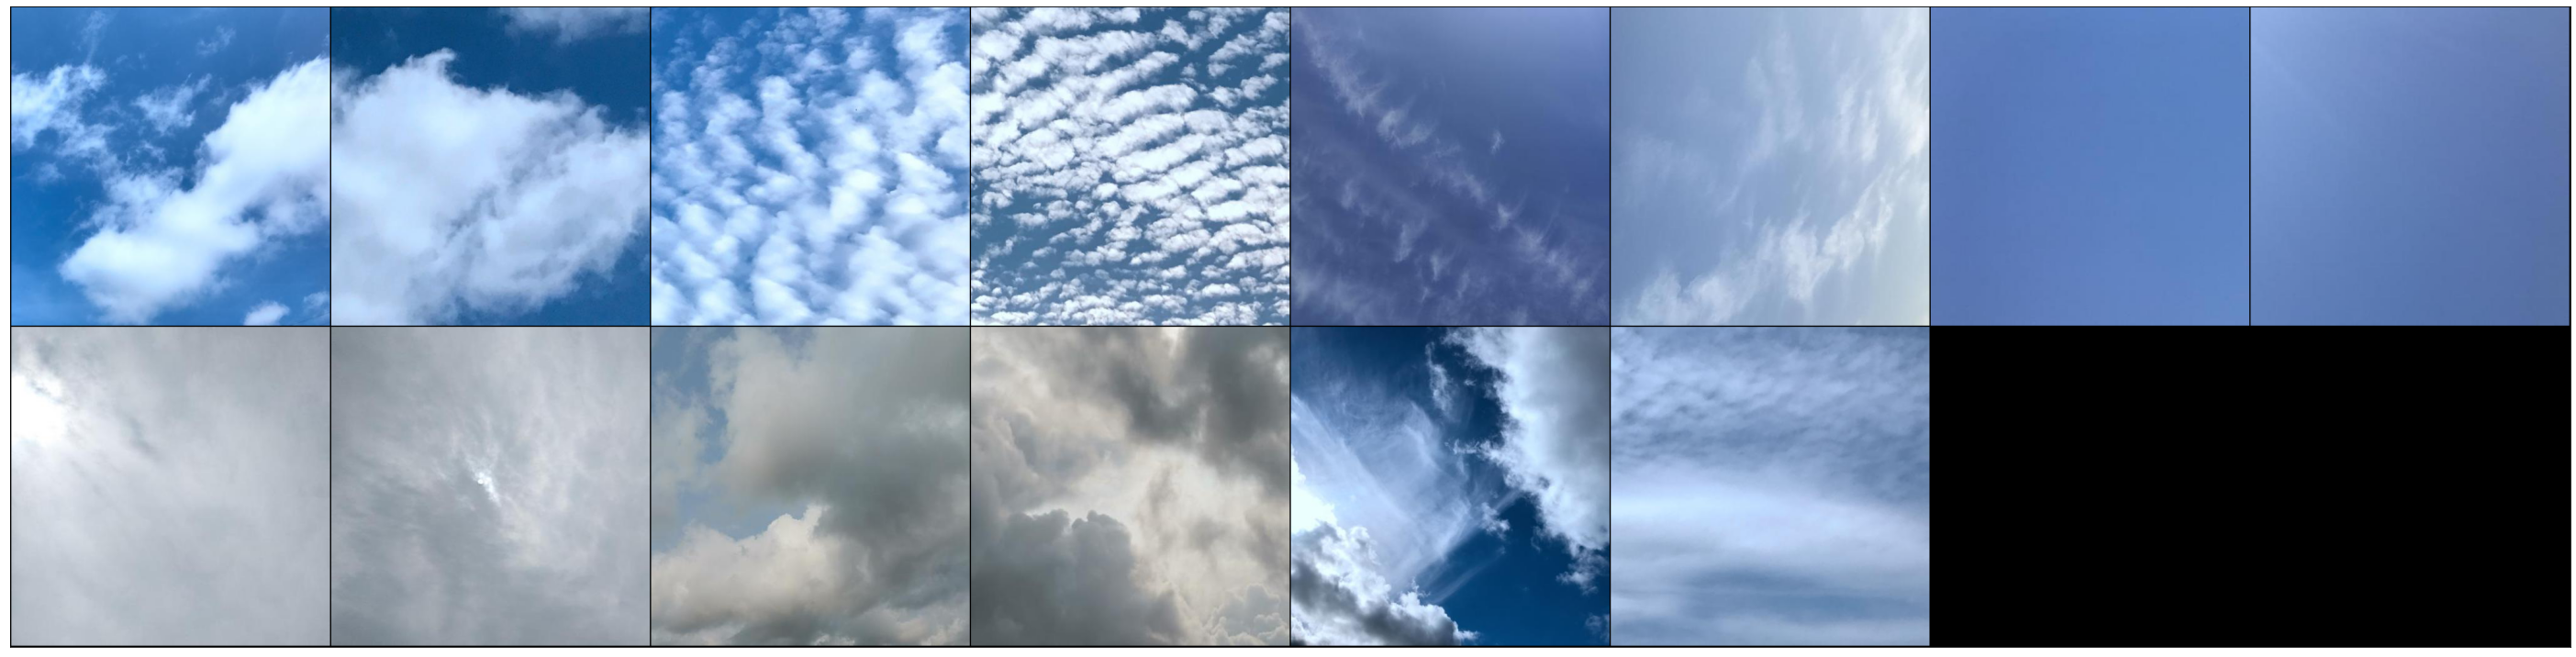

In [9]:
show(make_grid(images))

In [10]:
targets = [os.path.basename(x).split("_")[1] for x in paths]

df_data = pd.DataFrame({'target': targets})

df_data['label']= df_data['target'].map(class_mapper)

#### Graph construction

In [11]:
images = torch.tensor(np.array([utils.readImage(path) for path in paths]))

#NORM
images=(images-155.5673)/70.5983

In [28]:
model = GATConvGNN(7)
model_filename = "/new_inference/1_BIG_GRAPH.pt"
model.load_state_dict(torch.load(config.SAVE_PATH+model_filename))

model.eval()
print('ok')

ok


In [33]:
THRESHOLD=0.7

with torch.no_grad():
    features = model.get_deep_features(images)
    preds = torch.argmax(torch.nn.functional.softmax(model(images)[0],dim=1),dim=1).numpy()
    # Normalization
    norm = features.norm(dim=1).view(-1,1)
    batch = features/norm

    # Cosine Similarity Matrix NxN
    sim_matrix = batch @ batch.T

    #Adjacency Matrix NxN
    adj_matrix = torch.where(sim_matrix>THRESHOLD, 1, 0)

In [34]:
(df_data['label'].values == preds).sum()/len(preds)

0.2857142857142857

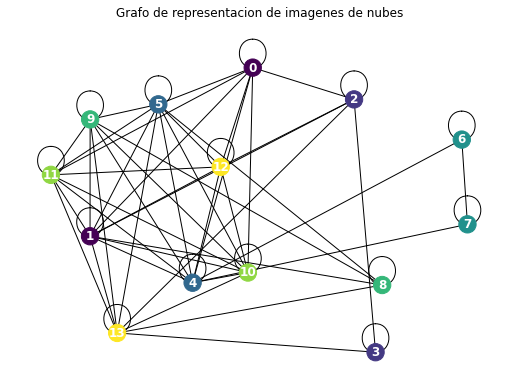

In [14]:
G = nx.from_numpy_matrix(adj_matrix.numpy(), create_using=nx.Graph)

plt.figure(1,figsize=(7,5)) 
nx.draw(G, nx.spring_layout(G, k=10/np.sqrt(G.number_of_nodes())), with_labels=True, node_color=df_data['label'], font_color="white", font_weight="bold")
plt.title('Grafo de representacion de imagenes de nubes')
plt.show()

# Experimento 1: predecir cada imagen de test usando el grafo de imagenes de entrenamiento como proxy para capturar correlaciones

In [15]:
test_image_paths = utils.get_gcd_paths(config.DATA_DIR, 'test')
test_names = [os.path.basename(x).split(".")[0] for x in test_image_paths]
test_targets = torch.tensor(pd.Series([os.path.basename(x).split("_")[1] for x in test_image_paths]).map(class_mapper).values, dtype=torch.long)

In [16]:
test_images = torch.tensor(np.array([utils.readImage(path) for path in test_image_paths]))

In [17]:
test_images=(test_images-155.5673)/70.5983

#### Prueba para 1 imagen de test de clase cumulus

data: (name, loss, prediction, target)

In [18]:
loss = nn.CrossEntropyLoss(reduction='none')

In [19]:
pred_images = torch.cat([images, test_images[0].unsqueeze(0)], dim=0)

In [20]:
THRESHOLD=0.7

with torch.no_grad():
    features_test = model.get_deep_features(pred_images[:15])
    
# Normalization
norm = features_test.norm(dim=1).view(-1,1)
batch = features_test/norm

# Cosine Similarity Matrix NxN
sim_matrix_test = batch @ batch.T

#Adjacency Matrix NxN
adj_matrix_test = torch.where(sim_matrix_test>THRESHOLD, 1, 0)

In [21]:
df_ = pd.DataFrame({'label': (df_data['label'].tolist()+[0])})

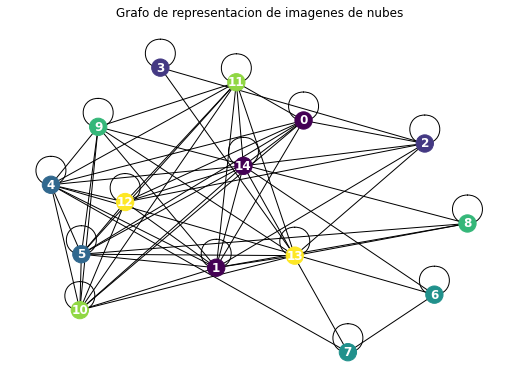

In [22]:
G = nx.from_numpy_matrix(adj_matrix_test.numpy(), create_using=nx.Graph)

plt.figure(1,figsize=(7,5)) 
nx.draw(G, nx.spring_layout(G, k=10/np.sqrt(G.number_of_nodes())), with_labels=True, node_color=df_['label'], font_color="white", font_weight="bold")
plt.title('Grafo de representacion de imagenes de nubes')
plt.show()

In [23]:
with torch.no_grad():
    logits_gnn, logits_cnn = model(pred_images)
    
    pred_gnn = torch.argmax(nn.functional.softmax(logits_gnn, dim=1),dim=1)[len(images)].item()
    pred_cnn = torch.argmax(nn.functional.softmax(logits_cnn, dim=1),dim=1)[len(images)].item()
    
    gnn_loss, cnn_loss = loss(logits_gnn[len(images)], test_targets[0]).item(), loss(logits_cnn[len(images)], test_targets[0]).item()
    
    print(f"GNN Loss: {gnn_loss:.4f} CNN Loss: {cnn_loss:.4f}")
    
    print(f"GNN Prediction: {pred_gnn} CNN Prediction: {pred_cnn}")

GNN Loss: 5.6238 CNN Loss: 4.5564
GNN Prediction: 5 CNN Prediction: 5


## Evaluation of all prediction images

`df_test: (name, target, gnn_loss, cnn_loss, gnn_prediction, cnn_prediction)`

In [24]:
model.to(config.DEVICE)
print('cuda')

cuda


In [25]:
gnn_losses = list()
cnn_losses = list()
gnn_predictions = list()
cnn_predictions = list()

for i, pred_img in enumerate(test_images[:100]):
    
    if i%100==0:
        print(f'Iteration {i+1}')
    pred_images = torch.cat([images, pred_img.unsqueeze(0)], dim=0).to(config.DEVICE)
    
    with torch.no_grad():
        logits_gnn, logits_cnn = model(pred_images)
        
        
        pred_gnn = torch.argmax(nn.functional.softmax(logits_gnn, dim=1),dim=1)[-1].item()
        pred_cnn = torch.argmax(nn.functional.softmax(logits_cnn, dim=1),dim=1)[-1].item()

        gnn_loss = loss(logits_gnn[-1], test_targets[i].to(config.DEVICE)).item()
        cnn_loss = loss(logits_cnn[-1], test_targets[i].to(config.DEVICE)).item()


        gnn_losses.append(gnn_loss)
        cnn_losses.append(cnn_loss)

        gnn_predictions.append(pred_gnn)
        cnn_predictions.append(pred_cnn)

Iteration 1


In [26]:
df_test = pd.DataFrame({
    'img_names': test_names[:100],
    'gnn_loss': gnn_losses,
    'cnn_loss': cnn_losses,
    'gnn_pred': gnn_predictions,
    'cnn_pred': cnn_predictions,
    'targets': test_targets[:100],
})

In [27]:
df_test['gnn_loss'].mean()

5.75019061177969

In [28]:
df_test['cnn_loss'].mean()

4.8034542460739615

In [29]:
from sklearn.metrics import accuracy_score

In [30]:
accuracy_score(df_test['targets'], df_test['gnn_pred'])

0.06

In [31]:
accuracy_score(df_test['targets'], df_test['cnn_pred'])

0.06

---